In [1]:
import numpy as np
import pandas as pd
import pennylane as qml
from susy_qm import calculate_wz_hamiltonian
from qiskit.quantum_info import SparsePauliOp
import itertools

from qutip import Qobj, concurrence, ptrace

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
a = 1.0
sites = [2]
potential_list = ['quadratic']#, 'quadratic']
bc_list = ['dirichlet']#, 'dirichlet']
cutoffs = [4]

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:

            data = {}
            data_qu = (int(np.log2(max(cutoffs))) + 1)*N
            for qubit1 in range(0, data_qu):
                    for qubit2 in range(qubit1 + 1, data_qu):
                            data[f"q{qubit1}-{qubit2}"] = []

            for cutoff in cutoffs:

                if potential == 'linear':
                    c=0
                else:
                    c=-0.2

                print(cutoff, N, a, potential, boundary_condition, c)
                H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c)

                eigenvalues, eigenvectors = np.linalg.eig(H)
                min_index = np.argmin(eigenvalues)
                min_eigenvalue = eigenvalues[min_index]
                min_eigenvector = np.asarray(eigenvectors[:, min_index])

                hamiltonian = SparsePauliOp.from_operator(H)
                num_qubits = hamiltonian.num_qubits

                psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
                rho = psi * psi.dag()

                cutoff_qubits = []
                for qubit1 in range(0, num_qubits):
                    for qubit2 in range(qubit1 + 1, num_qubits):
                        
                        rho_2q = ptrace(rho, [qubit1, qubit2])
                        c = concurrence(rho_2q)

                        col_name = f"q{qubit1}-{qubit2}"
                        data[col_name].append(c)

                        cutoff_qubits.append(col_name)

                nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
                for key in nan_qubits:
                    data[key].append(np.nan)

            data['cutoffs'] = cutoffs.copy()

4 2 1.0 quadratic dirichlet -0.2


In [3]:
d = data.copy()
cutoffs = d.pop('cutoffs')
ordered_data = {cutoff: sorted(((k, v[i]) for k, v in d.items()), key=lambda x: (np.isnan(x[1]), -x[1])) for i, cutoff in enumerate(cutoffs)}

df = pd.DataFrame({
    cutoff: [f"{pair[0]} ({pair[1]:.6f})" if not np.isnan(pair[1]) else f"{pair[0]} (nan)" 
             for pair in ordered_data[cutoff]]
    for cutoff in cutoffs
})



In [4]:
df.loc[0:15]

,4
0,q0-1 (0.740176)
1,q3-5 (0.054997)
2,q2-3 (0.034114)
3,q4-5 (0.034114)
4,q0-2 (0.000000)
5,q0-3 (0.000000)
6,q0-4 (0.000000)
7,q0-5 (0.000000)
8,q1-2 (0.000000)
9,q1-3 (0.000000)


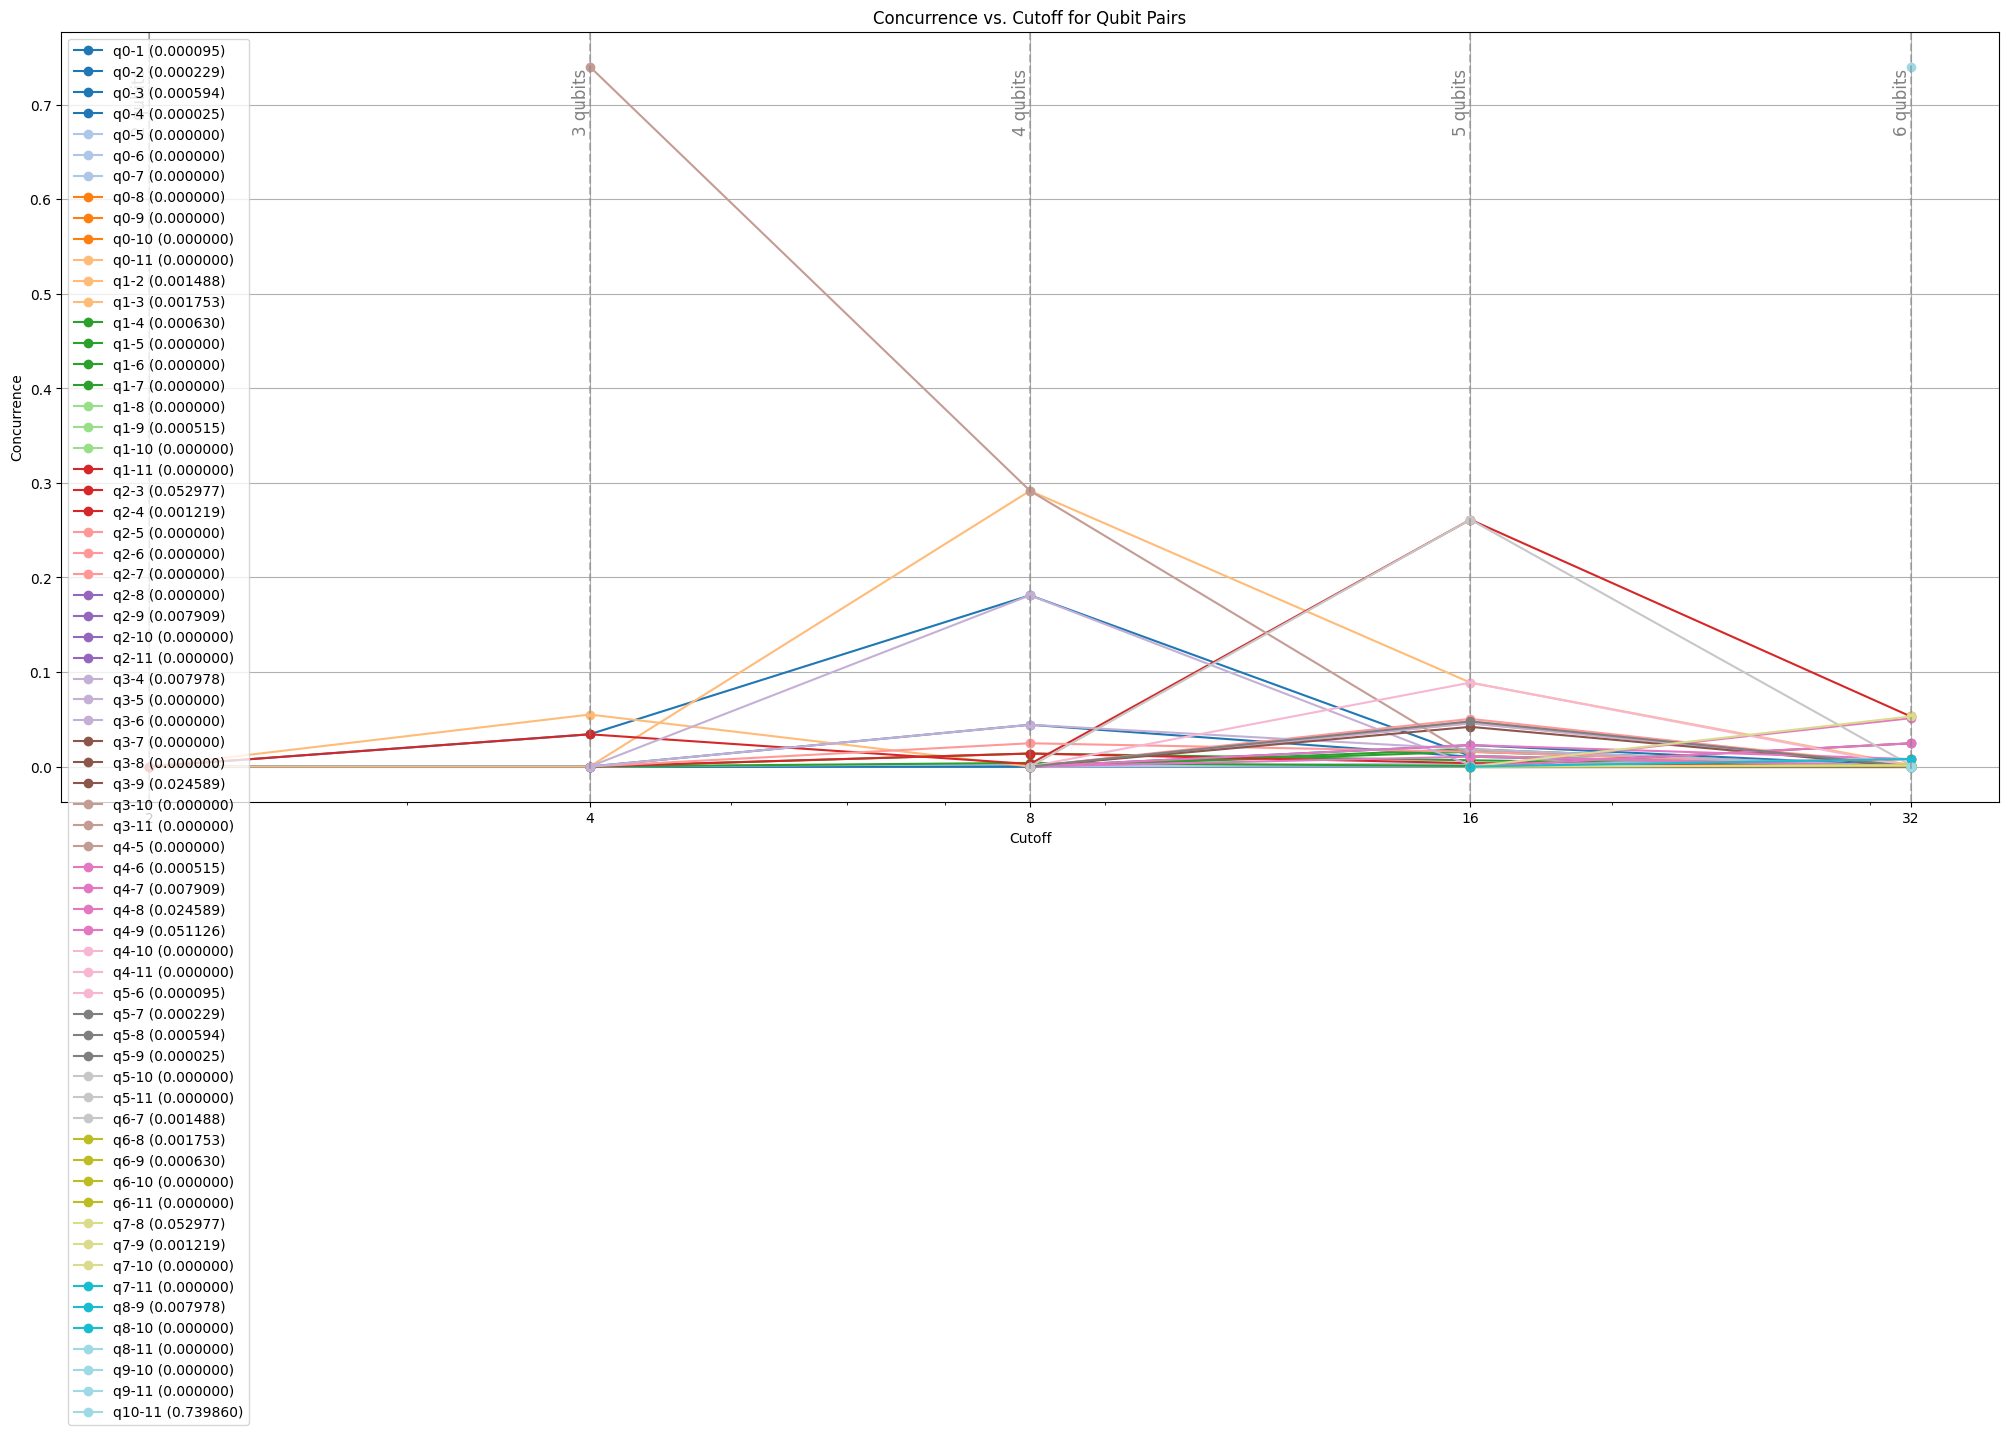

In [56]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key} ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Concurrence")
plt.title("Concurrence vs. Cutoff for Qubit Pairs")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\plot_{}".format(potential))